In [2]:
import sys
sys.path.append('..')
# import hijacobi
from hijacobi import Task, Spherically_Symmetric, repOfan
import torch
import matplotlib.pyplot as plt

00:52:35|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


In [3]:
# Setting model
metric_f = lambda r: 1 - 2/r + 0.2*torch.pow(r, -2)
BH = Spherically_Symmetric(f=metric_f)

# Setting up solver
Solver0 = repOfan(BH)
Solver0.set_Simpson()
Solver0.setup()
Solver0.setCustomIth(BH.Ith)

# Setting up task
th_s = torch.Tensor([torch.pi/2])
th_obs = torch.Tensor([torch.pi*84/180])

r_h = 2
r_ph = 3
r_end = 10
eps = 0.1

r_s = torch.Tensor([2.1, 2.4, 2.8, 3.2, 3.6, 4, 4.5, 5, 5.6])
r_obs = torch.Tensor([1000])

eq_data0 = [{'r_s': r_, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs, 'n_th':0, 'n_r':0} for r_ in r_s]
eq_data1 = [{'r_s': r_, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs, 'n_th':1, 'n_r':0} for r_ in r_s]
eq_data = eq_data0 + eq_data1

th_obs_test = th_s*2/3
test_data = [{'r_s': 2.01, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':0, 'n_r':0}]
test_data += [{'r_s': 2.01, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':1, 'n_r':0}]
test_data += [{'r_s': 2.2, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':0, 'n_r':0}]
test_data += [{'r_s': 2.2, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':1, 'n_r':0}]
# test_data += [{'r_s': 3.21, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':0, 'n_r':0}]
# test_data += [{'r_s': 3.21, 'r_obs': r_obs, 'th_s': th_s, 'th_obs': th_obs_test, 'n_th':1, 'n_r':0}]
# Инициализация задачи
Task_test = Task(BH, test_data)

Task_test.set_solver(Solver0)

Test passed, setting fuction as Ith


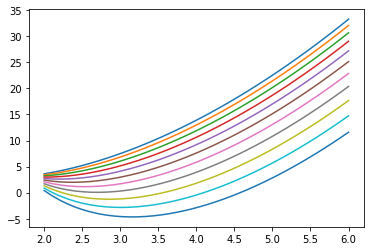

In [28]:
K = torch.linspace(2, 6, 11)
r = torch.linspace(2, 6, 40)

metric_f = lambda r: 1 - 2/r + 0.4/r**2
eq = lambda r, K: r**2-K**2*metric_f(r)

rK = torch.meshgrid(r, K, indexing='ij')

fig, ax = plt.subplots(1,1)
ax.plot(r, eq(rK[0], rK[1]))
plt.show()

In [48]:
res = Task_test.solve()

Solving Eq # 0  conditions:  {'r_s': 2.01, 'r_obs': tensor([1000.]), 'th_s': tensor([1.5708]), 'th_obs': tensor([1.0472]), 'n_th': 0, 'n_r': 0, 'res': None}
Solving Eq # 1  conditions:  {'r_s': 2.01, 'r_obs': tensor([1000.]), 'th_s': tensor([1.5708]), 'th_obs': tensor([1.0472]), 'n_th': 1, 'n_r': 0, 'res': None}
Solving Eq # 2  conditions:  {'r_s': 2.2, 'r_obs': tensor([1000.]), 'th_s': tensor([1.5708]), 'th_obs': tensor([1.0472]), 'n_th': 0, 'n_r': 0, 'res': None}
Solving Eq # 3  conditions:  {'r_s': 2.2, 'r_obs': tensor([1000.]), 'th_s': tensor([1.5708]), 'th_obs': tensor([1.0472]), 'n_th': 1, 'n_r': 0, 'res': None}


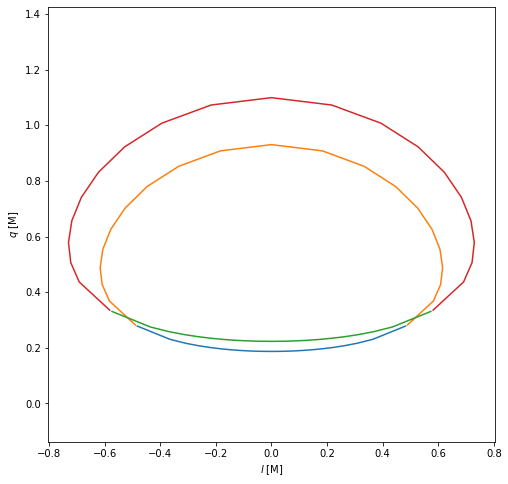

In [50]:
N_eq = Task_test.N_eq

fig, ax = plt.subplots(1,1, figsize=(8,8))

for eqN in range(N_eq):
    gma_s = res[eqN]['res'][0]
    p_s = res[eqN]['res'][1]

    # err = res[eqN]['err']
    # mask_t = torch.less(abs(err), 1e-4)
    # gma_true = gma_s[mask_t]
    # p_true = p_s[mask_t]

    l_s = Solver0.L(gma_s, p_s)
    q_s = Solver0.Q(gma_s, p_s)

    # ax.plot(l_true, q_true)
    ax.plot(l_s, q_s)
    ax.set_xlabel('$l$ [M]')
    ax.set_ylabel('$q$ [M]')
    ax.axis('equal')


In [38]:
def coors(BH, l, q, bc):
    alpha = -l/torch.sin(bc['th_obs'])
    beta = torch.sqrt(BH.uTh(bc['th_obs'], l, q))

    return alpha.flatten(), beta.flatten()



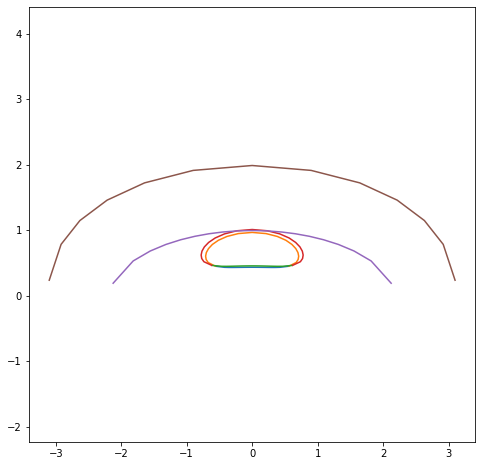

In [39]:
N_eq = Task_test.N_eq
fig, ax = plt.subplots(1,1, figsize=(8,8))

for eqN in range(N_eq):
    gma_s = res[eqN]['res'][0]
    p_s = res[eqN]['res'][1]

    # err = res[eqN]['err']
    # mask_t = torch.less(abs(err), 1e-4)
    # gma_true = gma_s[mask_t]
    # p_true = p_s[mask_t]
    l_s = Solver0.L(gma_s, p_s)
    q_s = Solver0.Q(gma_s, p_s)
    alph, bta = coors(Task_test.BH, l_s, q_s, Task_test.eq_data[eqN])
    
    # ax.plot(l_true, q_true)
    ax.plot(alph, bta)
    ax.axis('equal')

In [13]:
class particle():

    def __init__(self, BH, useAbs: False):
        self.BH = BH
        if useAbs:
            self.xabs = lambda x: abs(x)


    def xabs(self, X):
        return X


    def p_t(self, X, l, q):
        return None


    def p_r(self, X, l, q, sign=True):
        
        if sign:
            sign = self.sign_p(X, l, q)
        else:
            sign = 1

        val = torch.sqrt(self.xabs(self.BH.uR()))

        return null


    def p_th(self, X, l, q, sign=True):

        if sign:
            sign = self.sign_p(X, l, q)
        else:
            sign = 1

        val = torch.sqrt(self.xabs(self.BH.uR()))

        return

    
    def p_phi(self, X, l, q, sign=True):

        if sign:
            sign = self.sign_p(X, l, q)
        else:
            sign = 1

        val = torch.sqrt(self.xabs(self.BH.uR()))

        return 




IndentationError: expected an indented block after function definition on line 6 (2808857078.py, line 8)